In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_table('data/parsed_officers.txt', header=None)

The first step in network analysis is getting a unique list of companies and directors. Since we wish to identify directors with multiple seats, we obviously expect the present matrix to have duplications.

In [3]:
data = data[[0,1]].dropna()
# for now, avoiding complications of missing titles
companies = data[0].unique()
directors = data[1].unique()

dir_v_com = np.zeros((len(companies),len(directors)))

Next, we use each unique entry as a dictionary key; this way, we can quickly find the row or a column corresponding to a company or a director. Then we iterate through the entire table and fill out an adjacency matrix listing which directors are in which companies.

In [4]:
dir_dict, com_dict = dict(), dict()
for ix, direc in enumerate(directors):
    dir_dict[direc] = (ix, direc)
for ix, compa in enumerate(companies):
    com_dict[compa] = (ix, compa)

for row in data.values:
    dir_v_com[com_dict[row[0]][0],dir_dict[row[1]][0]] = 1

In [5]:
import networkx as nx
import joblib

Finally, we import a graph library and use a trick of matrix multiplication to find out how closely related various companies are to each other and various directors are to each other; then we draw these graphs using multidimensional scaling to roughly represent the distances the matrix multiplication creates.

In [6]:
com_adj = np.dot( dir_v_com , np.transpose(dir_v_com) )
dir_adj = np.dot( np.transpose(dir_v_com) , dir_v_com )

In [7]:
g_dir = nx.from_numpy_matrix(dir_adj)
g_com = nx.from_numpy_matrix(com_adj)

In [8]:
import warnings
warnings.filterwarnings('ignore')
# networkx library not up-to-date on matplotlib
import matplotlib.pyplot as plt

In [9]:
from collections import deque
def get_info(name, size=1, entity_type='company'):
    if entity_type == 'company':
        adj = g_com
        dic = com_dict
        revdic = companies
    if entity_type == 'director':
        adj = g_dir
        dic = dir_dict
        revdic = directors
    visited_nodes = set()
    nodes_to_visit = deque()
    nodes_to_visit.append(dic[name][0])
    for i in range(size):
        this_node = nodes_to_visit.popleft()
        for node in adj.neighbors(this_node):
            if node not in visited_nodes:
                visited_nodes.add(node)
                nodes_to_visit.append(node)
    nodes = list(visited_nodes)
    sg = adj.subgraph(nodes)
    sensible_labels = dict()
    for node in sg.nodes():
        sensible_labels[node] = revdic[node]
    nx.relabel_nodes(sg, sensible_labels, copy=False)
    nx.draw(sg, with_labels=True)
    plt.show()

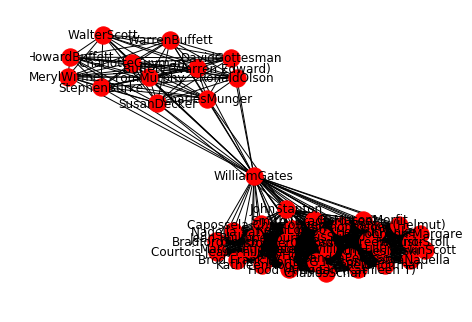

In [10]:
get_info('WilliamGates', entity_type='director')

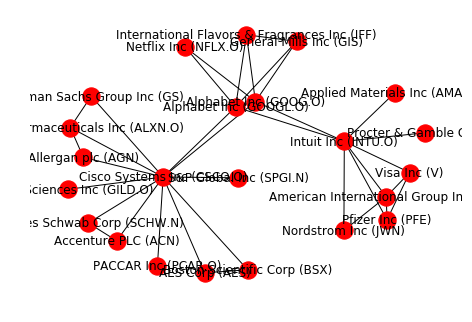

In [11]:
get_info('Alphabet Inc (GOOG.O)', 3, entity_type='company')

In [ ]:
# Takes way too long to run; library problem...
#b_cen_com = nx.betweenness_centrality(g_com)
#b_cen_dir = nx.betweenness_centrality(g_dir)

As a final step, I export the graphs in graphml format for prettier viewing with Cytoscape.

In [12]:
nx.write_graphml(g_dir, 'directors.graphml')
nx.write_graphml(g_com, 'companies.graphml')